
 # Stock Price Time Series Analytics 
 ---------------------------------------
#### Author: Upesh Khairnar
#### Description:
 This project analyzes historical stock price data, identifies patterns, and applies ARIMA, SARIMA, and LSTM models to forecast short-term prices.


## Problem Statement

The objective of this project is to analyze historical stock price data of Apple Inc.
and apply time-series forecasting techniques to predict future closing prices.

This project compares traditional statistical models (ARIMA, SARIMA) with a deep
learning-based model (LSTM) to evaluate their forecasting performance.





Models are evaluated using RMSE, MAE, and accuracy-like metrics.

In [ ]:
# -------------------------------
# 1. Import Libraries
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

ImportError: Traceback (most recent call last):
  File "c:\Users\upesh\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
print("Libraries imported successfully.")

In [ ]:
# -------------------------------
# 2. Load Dataset
# -------------------------------

# using Yahoo finance downloaded dataset of apple stock price
df = pd.read_csv("Dataset/apple_stock.csv")

# Drop rows where 'Date' is NaN
df = df.dropna(subset=['Date'])

# Reset index
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Close,High,Low,Open,Volume
0,2015-01-02,24.26104736328125,24.729270393437197,23.821671579713147,24.718174386973395,212818400
1,2015-01-05,23.57756996154785,24.110145998105324,23.391169279909636,24.030259507971074,257142000
2,2015-01-06,23.579792022705078,23.83942229690088,23.218083238966898,23.64192558989593,263188400
3,2015-01-07,23.91042709350586,24.01028434847797,23.677424574554454,23.78837783252896,160423600
4,2015-01-08,24.82912826538086,24.886824452930725,24.121245700213183,24.23885761526062,237458000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2264 non-null   datetime64[ns]
 1   Close         2264 non-null   float64       
 2   High          2264 non-null   object        
 3   Low           2264 non-null   object        
 4   Open          2264 non-null   object        
 5   Volume        2264 non-null   object        
 6   rolling_mean  2235 non-null   float64       
 7   rolling_std   2235 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 141.6+ KB


In [28]:
# Converting Close col to numaric
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Converting Date col to Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [27]:
df.describe()

,rolling_mean,rolling_std
count,2235.000000,2235.000000
mean,81.123020,3.052208
std,55.372049,2.451968
min,21.788941,0.335305
25%,33.195616,0.966719
50%,51.196285,2.103169
75%,139.179201,4.693617
max,191.328483,11.827124


In [ ]:
# Dataset Summary

# Date → The trading day (weekends/holidays missing since markets are closed).

# Open → Price at which the stock opened trading that day.

# High → Highest price reached during that day.

# Low → Lowest price reached during that day.

# Close → Price at which the stock closed at end of trading session.

# Adj Close → “Adjusted Close” → Close price adjusted for stock splits/dividends.
# For analysis/ML, we usually use Adj Close because it’s corrected historically.

# Volume → Number of shares traded that day.

## Exploratory Data Analysis (EDA)


### Data Cleaning Steps
- Converted Date column to datetime format for time-series analysis
- Converted Close price to numeric to avoid calculation errors
- Removed missing values to ensure model stability


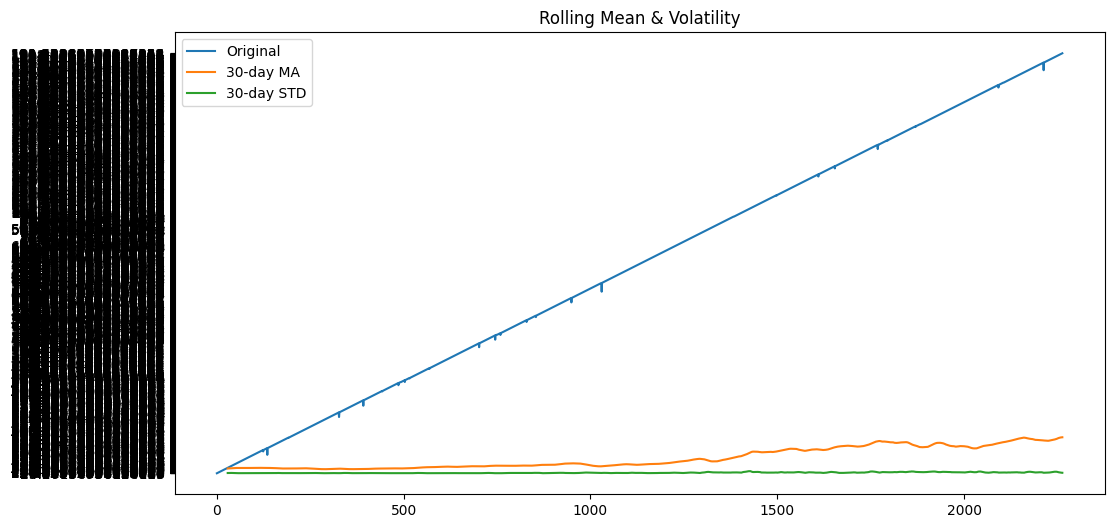

In [22]:
# -------------------------------
# 3. Exploratory Data Analysis
# -------------------------------

# Interactive plot using Plotly
fig = px.line(df, x=df.index, y="Close", title="Apple Stock Price Trend")
fig.show()

# Rolling statistics (trend & volatility)
df['rolling_mean'] = df['Close'].rolling(window=30).mean()
df['rolling_std'] = df['Close'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label="Original")
plt.plot(df['rolling_mean'], label="30-day MA")
plt.plot(df['rolling_std'], label="30-day STD")
plt.legend()
plt.title("Rolling Mean & Volatility")
plt.show()

In [ ]:
# Volume Analysis
px.bar(df, x="Date", y="Volume", title="Trading Volume Over Time")

# Daily Returns
df['Daily_Return'] = df['Close'].pct_change()
px.line(df, x="Date", y="Daily_Return", title="Daily Returns")

# Moving Averages
df['MA_20'] = df['Close'].rolling(20).mean()
df['MA_50'] = df['Close'].rolling(50).mean()


## Stationarity Check using ADF Test



### Stationarity Test Interpretation

The Augmented Dickey-Fuller (ADF) test checks whether the time series is stationary.
A p-value less than 0.05 indicates stationarity.

Since the p-value is greater than 0.05, the series is non-stationary and requires differencing.


In [24]:
# -------------------------------
# 4. Stationarity Test (ADF Test)
# -------------------------------
result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])  # If < 0.05 => Stationary  else non-stationary


ADF Statistic: 0.24379456348445333
p-value: 0.9746136600585787


## Model 1: ARIMA


## ARIMA Model

### Why this model?
ARIMA (AutoRegressive Integrated Moving Average) is a classical time-series forecasting model used to capture linear patterns in historical data. It is suitable for forecasting stock prices when the data shows temporal dependency and can be made stationary through differencing. This model acts as a strong statistical baseline for comparison.

### What assumptions does it make?
- The time series is stationary or can be made stationary using differencing  
- Linear relationship exists between past observations  
- No strong seasonality is present  
- Model residuals are independent and normally distributed  

### What type of data does it work best on?
- Univariate time-series data  
- Data with trend but no strong seasonality  
- Short to medium-term forecasting problems  
- Time-series data where past values influence future values  



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1811
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3212.157
Date:                Wed, 20 Aug 2025   AIC                           6436.315
Time:                        06:50:12   BIC                           6469.321
Sample:                             0   HQIC                          6448.496
                               - 1811                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0521      0.013     -4.103      0.000      -0.077      -0.027
ar.L2         -0.0002      0.012     -0.020      0.984      -0.024       0.023
ar.L3         -0.0390      0.014     -2.811      0.0

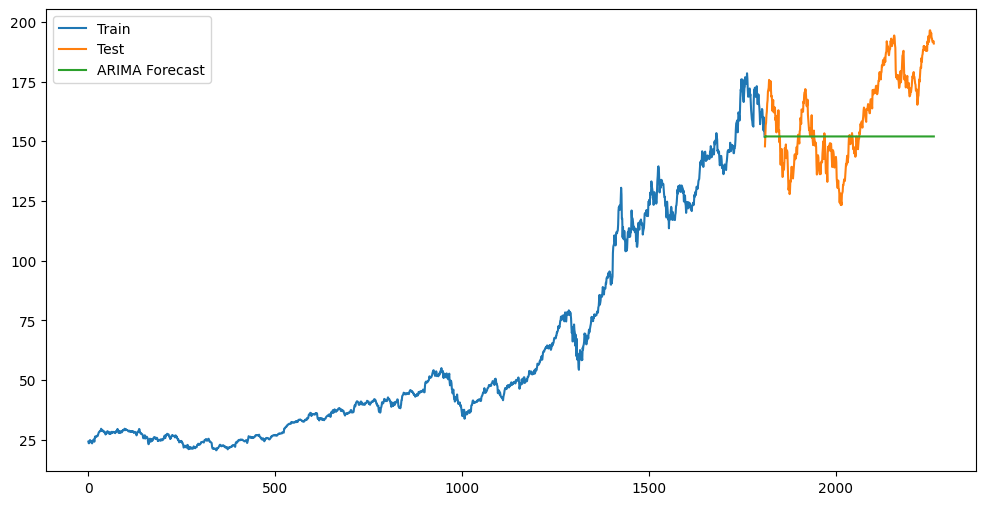

In [ ]:
# -------------------------------
# 5. ARIMA Model
# -------------------------------
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

model_arima = ARIMA(train, order=(5, 1, 0))
arima_fit = model_arima.fit()
print(arima_fit.summary())

# Forecast
forecast_arima = arima_fit.forecast(steps=len(test))
rmse_arima = sqrt(mean_squared_error(test, forecast_arima))
print("ARIMA RMSE:", rmse_arima)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


In [ ]:
# ARIMAforecast plot
plt.figure(figsize=(12,6))
plt.plot(test.values, label="Actual")
plt.plot(forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


## Model 2: SARIMA


## SARIMA Model

### Why this model?
SARIMA (Seasonal AutoRegressive Integrated Moving Average) extends ARIMA by explicitly modeling seasonal patterns in the data. Stock prices may exhibit seasonal or cyclical behavior due to market cycles, quarterly earnings, or yearly trends, making SARIMA more suitable than ARIMA in such scenarios.

### What assumptions does it make?
- The time series can be made stationary  
- Seasonal patterns are consistent over time  
- Linear dependency exists between observations  
- Residuals are independent and normally distributed  

### What type of data does it work best on?
- Univariate time-series data with seasonality  
- Financial and economic data with recurring cycles  
- Medium-term forecasting where seasonal trends matter  



SARIMA RMSE: 20.525524010427397


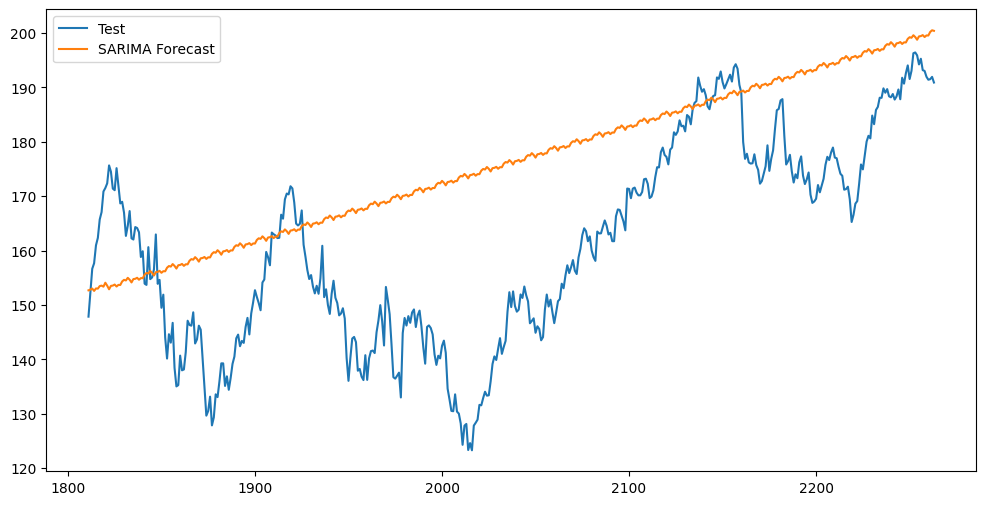

In [ ]:
# -------------------------------
# 6. SARIMA Model
# -------------------------------
sarima_model = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

forecast_sarima = sarima_fit.predict(start=len(train), end=len(df)-1, dynamic=False)
rmse_sarima = sqrt(mean_squared_error(test, forecast_sarima))
print("SARIMA RMSE:", rmse_sarima)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast_sarima, label="SARIMA Forecast")
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()


## Model 3: LSTM


## LSTM Model

### Why this model?
LSTM (Long Short-Term Memory) is a type of recurrent neural network designed to learn long-term dependencies in sequential data. Unlike traditional statistical models, LSTM can capture complex non-linear relationships, making it suitable for modeling volatile and dynamic stock price movements.

### What assumptions does it make?
- No strict requirement for stationarity  
- Availability of sufficient historical data for training  
- Presence of non-linear patterns in the data  
- Sequential dependency in the time series  

### What type of data does it work best on?
- Large-scale time-series datasets  
- Data with complex and non-linear patterns  
- Long-term dependency forecasting problems  
- Highly volatile financial time-series data  


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0288
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.1880e-04
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 3.3851e-04
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 3.5746e-04
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 3.9210e-04
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 3.2242e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.1740e-04
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2.5777e-04
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 2.6821e-04
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.6200e-04
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
LSTM RMSE: 5.857225228409154


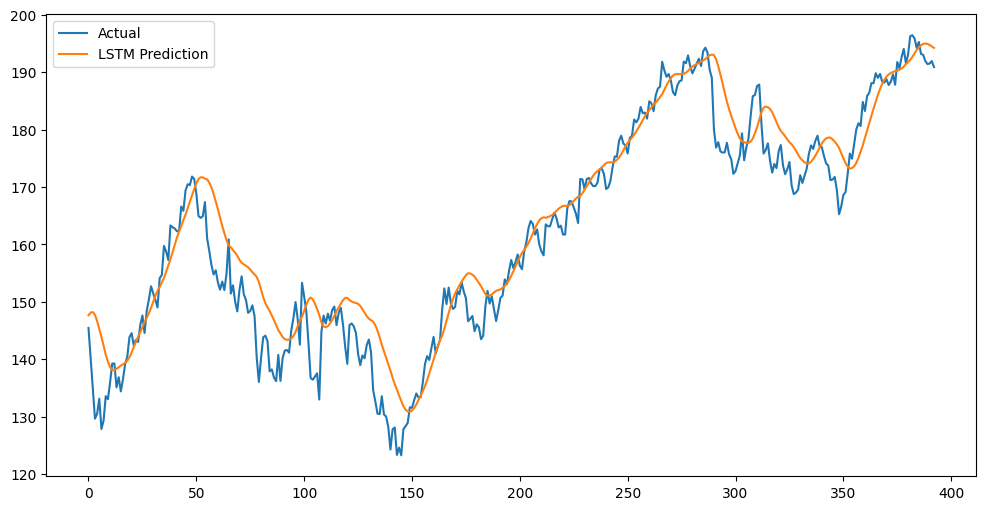

In [ ]:
# -------------------------------
# 7. LSTM Model
# -------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Prepare training data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_lstm = sqrt(mean_squared_error(y_test_rescaled, y_pred))
print("LSTM RMSE:", rmse_lstm)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred, label="LSTM Prediction")
plt.legend()
plt.title("LSTM Prediction vs Actual")
plt.show()


In [35]:
# -------------------------------
# 8. Final Comparison
# -------------------------------
print(f"Model Comparison:\nARIMA RMSE = {rmse_arima:.2f}\nSARIMA RMSE = {rmse_sarima:.2f}\nLSTM RMSE = {rmse_lstm:.2f}")


Model Comparison:
ARIMA RMSE = 20.60
SARIMA RMSE = 20.53
LSTM RMSE = 5.86


In [ ]:
# models exporting 

# import os
# os.makedirs("models", exist_ok=True)


import os
import joblib

# Saving ARIMA Model 
os.makedirs("models", exist_ok=True)
joblib.dump(arima_fit, "models/arima_model.pkl")
print("ARIMA model exported successfully!")

# saving SARIMA Model 
joblib.dump(sarima_fit, "models/sarima_model.pkl")
print("SARIMA model exported successfully!")


# Save LSTM model
model_lstm.save("models/lstm_model.keras")

# Save scaler
joblib.dump(scaler, "models/lstm_scaler.pkl")

print("LSTM model and scaler exported successfully!")


